In [1]:
# import packages
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Variables
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_35.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_35.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'

/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 访问最后一个隐藏层的最后一个token的隐藏状态
        # hidden_states[-1]表示最后一个隐藏层，mean(dim=1)表示取所有头的均值
        last_layer_hidden_states = outputs.hidden_states[-1]
        last_token_hidden_states = last_layer_hidden_states[:, -1, :]  # -1表示最后一个token
        hidden_states.append(last_token_hidden_states.cpu().numpy())
    return np.vstack(hidden_states)

In [4]:
# lode data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')  # Initialize the best accuracy to negative infinity
    best_f1 = -float('inf')  # Initialize the best F1-score to negative infinity
    best_model_state = None  # Store the state of the best model
    best_epoch = 0  # Track the epoch with the best accuracy
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # Calculate F1-score
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Check if the current model is the best based on F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Best Model was saved at epoch {best_epoch} with F1-score {best_f1:.4f} and accuracy {best_accuracy * 100:.2f}%")
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement = load_data(non_infringement_file, infringement_file)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


In [ ]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)

Extracting hidden states for non_infringement texts...


Processing data batches:   1%|          | 2/232 [00:02<04:37,  1.20s/it]

In [ ]:
split_index_non_infringement = int(0.8 * len(X_non_infringement))
X_non_infringement_train = X_non_infringement[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement))
X_infringement_train = X_infringement[:split_index_infringement]
X_infringement_test = X_infringement[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")


Data successfully split into training and test sets.


Training Epochs:   0%|          | 10/2500 [00:03<08:19,  4.98it/s]

Epoch 10/2500, Loss: 1.1196
Test Accuracy at Epoch 10: 65.88%
Test F1-score at Epoch 10: 0.7162
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.80      0.45      0.57       195
non_infringement       0.60      0.88      0.72       186

        accuracy                           0.66       381
       macro avg       0.70      0.66      0.64       381
    weighted avg       0.70      0.66      0.64       381

New best model saved with F1-score 0.7162 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.80      0.45      0.57       195
non_infringement       0.60      0.88      0.72       186

        accuracy                           0.66       381
       macro avg       0.70      0.66      0.64       381
    weighted avg       0.70      0.66      0.64       381



Training Epochs:   1%|          | 21/2500 [00:04<05:24,  7.64it/s]

Epoch 20/2500, Loss: 0.4699
Test Accuracy at Epoch 20: 54.59%
Test F1-score at Epoch 20: 0.3799
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.54      0.79      0.64       195
non_infringement       0.57      0.28      0.38       186

        accuracy                           0.55       381
       macro avg       0.55      0.54      0.51       381
    weighted avg       0.55      0.55      0.51       381



Training Epochs:   1%|          | 30/2500 [00:08<17:19,  2.38it/s]

Epoch 30/2500, Loss: 0.4449
Test Accuracy at Epoch 30: 63.52%
Test F1-score at Epoch 30: 0.6085
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.63      0.69      0.66       195
non_infringement       0.64      0.58      0.61       186

        accuracy                           0.64       381
       macro avg       0.64      0.63      0.63       381
    weighted avg       0.64      0.64      0.63       381



Training Epochs:   2%|▏         | 40/2500 [00:08<03:40, 11.17it/s]

Epoch 40/2500, Loss: 0.3826
Test Accuracy at Epoch 40: 66.93%
Test F1-score at Epoch 40: 0.6818
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       195
non_infringement       0.64      0.73      0.68       186

        accuracy                           0.67       381
       macro avg       0.67      0.67      0.67       381
    weighted avg       0.67      0.67      0.67       381



Training Epochs:   2%|▏         | 50/2500 [00:12<14:21,  2.84it/s]

Epoch 50/2500, Loss: 0.3451
Test Accuracy at Epoch 50: 69.03%
Test F1-score at Epoch 50: 0.7108
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.74      0.61      0.67       195
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.69       381
       macro avg       0.70      0.69      0.69       381
    weighted avg       0.70      0.69      0.69       381



Training Epochs:   2%|▏         | 61/2500 [00:14<08:55,  4.55it/s]

Epoch 60/2500, Loss: 0.3127
Test Accuracy at Epoch 60: 68.50%
Test F1-score at Epoch 60: 0.6809
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.70      0.68      0.69       195
non_infringement       0.67      0.69      0.68       186

        accuracy                           0.69       381
       macro avg       0.69      0.69      0.68       381
    weighted avg       0.69      0.69      0.69       381



Training Epochs:   3%|▎         | 70/2500 [00:17<18:30,  2.19it/s]

Epoch 70/2500, Loss: 0.2827
Test Accuracy at Epoch 70: 67.72%
Test F1-score at Epoch 70: 0.6822
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.70      0.65      0.67       195
non_infringement       0.66      0.71      0.68       186

        accuracy                           0.68       381
       macro avg       0.68      0.68      0.68       381
    weighted avg       0.68      0.68      0.68       381



Training Epochs:   3%|▎         | 80/2500 [00:18<06:41,  6.03it/s]

Epoch 80/2500, Loss: 0.2612
Test Accuracy at Epoch 80: 68.24%
Test F1-score at Epoch 80: 0.7027
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.73      0.60      0.66       195
non_infringement       0.65      0.77      0.70       186

        accuracy                           0.68       381
       macro avg       0.69      0.68      0.68       381
    weighted avg       0.69      0.68      0.68       381



Training Epochs:   4%|▎         | 92/2500 [00:22<05:51,  6.84it/s]

Epoch 90/2500, Loss: 0.2370
Test Accuracy at Epoch 90: 66.93%
Test F1-score at Epoch 90: 0.6850
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.71      0.61      0.65       195
non_infringement       0.64      0.74      0.69       186

        accuracy                           0.67       381
       macro avg       0.67      0.67      0.67       381
    weighted avg       0.67      0.67      0.67       381



Training Epochs:   4%|▍         | 100/2500 [00:23<07:21,  5.44it/s]

Epoch 100/2500, Loss: 0.2275
Test Accuracy at Epoch 100: 67.72%
Test F1-score at Epoch 100: 0.6755
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.69      0.67      0.68       195
non_infringement       0.66      0.69      0.68       186

        accuracy                           0.68       381
       macro avg       0.68      0.68      0.68       381
    weighted avg       0.68      0.68      0.68       381



Training Epochs:   4%|▍         | 110/2500 [00:24<07:29,  5.32it/s]

Epoch 110/2500, Loss: 0.2629
Test Accuracy at Epoch 110: 70.87%
Test F1-score at Epoch 110: 0.7338
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.78      0.60      0.68       195
non_infringement       0.66      0.82      0.73       186

        accuracy                           0.71       381
       macro avg       0.72      0.71      0.71       381
    weighted avg       0.72      0.71      0.71       381

New best model saved with F1-score 0.7338 at epoch 110
Best Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.78      0.60      0.68       195
non_infringement       0.66      0.82      0.73       186

        accuracy                           0.71       381
       macro avg       0.72      0.71      0.71       381
    weighted avg       0.72      0.71      0.71       381



Training Epochs:   5%|▍         | 119/2500 [00:27<06:01,  6.59it/s]

Epoch 120/2500, Loss: 0.2132
Test Accuracy at Epoch 120: 68.24%
Test F1-score at Epoch 120: 0.6952
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.72      0.63      0.67       195
non_infringement       0.65      0.74      0.70       186

        accuracy                           0.68       381
       macro avg       0.69      0.68      0.68       381
    weighted avg       0.69      0.68      0.68       381



Training Epochs:   5%|▌         | 131/2500 [00:31<08:39,  4.56it/s]

Epoch 130/2500, Loss: 0.1960
Test Accuracy at Epoch 130: 67.98%
Test F1-score at Epoch 130: 0.6935
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.72      0.62      0.66       195
non_infringement       0.65      0.74      0.69       186

        accuracy                           0.68       381
       macro avg       0.68      0.68      0.68       381
    weighted avg       0.68      0.68      0.68       381



Training Epochs:   6%|▌         | 140/2500 [00:33<10:06,  3.89it/s]

Epoch 140/2500, Loss: 0.2653
Test Accuracy at Epoch 140: 65.35%
Test F1-score at Epoch 140: 0.6118
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.64      0.74      0.69       195
non_infringement       0.68      0.56      0.61       186

        accuracy                           0.65       381
       macro avg       0.66      0.65      0.65       381
    weighted avg       0.66      0.65      0.65       381



Training Epochs:   6%|▌         | 151/2500 [00:36<07:02,  5.55it/s]

Epoch 150/2500, Loss: 0.2026
Test Accuracy at Epoch 150: 67.45%
Test F1-score at Epoch 150: 0.6771
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.69      0.65      0.67       195
non_infringement       0.66      0.70      0.68       186

        accuracy                           0.67       381
       macro avg       0.68      0.68      0.67       381
    weighted avg       0.68      0.67      0.67       381



Training Epochs:   6%|▋         | 162/2500 [00:37<02:18, 16.87it/s]

Epoch 160/2500, Loss: 0.1640
Test Accuracy at Epoch 160: 69.03%
Test F1-score at Epoch 160: 0.7079
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.74      0.62      0.67       195
non_infringement       0.66      0.77      0.71       186

        accuracy                           0.69       381
       macro avg       0.70      0.69      0.69       381
    weighted avg       0.70      0.69      0.69       381



Training Epochs:   7%|▋         | 168/2500 [00:37<01:59, 19.50it/s]

Epoch 170/2500, Loss: 0.1558
Test Accuracy at Epoch 170: 67.98%
Test F1-score at Epoch 170: 0.6904
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.71      0.63      0.67       195
non_infringement       0.65      0.73      0.69       186

        accuracy                           0.68       381
       macro avg       0.68      0.68      0.68       381
    weighted avg       0.68      0.68      0.68       381



Training Epochs:   7%|▋         | 181/2500 [00:41<06:56,  5.57it/s]

Epoch 180/2500, Loss: 0.2114
Test Accuracy at Epoch 180: 70.87%
Test F1-score at Epoch 180: 0.7338
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.78      0.60      0.68       195
non_infringement       0.66      0.82      0.73       186

        accuracy                           0.71       381
       macro avg       0.72      0.71      0.71       381
    weighted avg       0.72      0.71      0.71       381



Training Epochs:   8%|▊         | 189/2500 [00:42<04:27,  8.65it/s]

Epoch 190/2500, Loss: 0.1538
Test Accuracy at Epoch 190: 69.82%
Test F1-score at Epoch 190: 0.7188
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.75      0.61      0.67       195
non_infringement       0.66      0.79      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:   8%|▊         | 200/2500 [00:44<09:34,  4.00it/s]

Epoch 200/2500, Loss: 0.1686
Test Accuracy at Epoch 200: 67.72%
Test F1-score at Epoch 200: 0.6805
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.70      0.65      0.67       195
non_infringement       0.66      0.70      0.68       186

        accuracy                           0.68       381
       macro avg       0.68      0.68      0.68       381
    weighted avg       0.68      0.68      0.68       381



Training Epochs:   8%|▊         | 211/2500 [00:46<05:28,  6.97it/s]

Epoch 210/2500, Loss: 0.1473
Test Accuracy at Epoch 210: 67.45%
Test F1-score at Epoch 210: 0.6869
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.71      0.62      0.66       195
non_infringement       0.65      0.73      0.69       186

        accuracy                           0.67       381
       macro avg       0.68      0.68      0.67       381
    weighted avg       0.68      0.67      0.67       381



Training Epochs:   9%|▉         | 223/2500 [00:47<02:08, 17.78it/s]

Epoch 220/2500, Loss: 0.2245
Test Accuracy at Epoch 220: 65.62%
Test F1-score at Epoch 220: 0.6391
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.66      0.69      0.67       195
non_infringement       0.66      0.62      0.64       186

        accuracy                           0.66       381
       macro avg       0.66      0.66      0.66       381
    weighted avg       0.66      0.66      0.66       381



Training Epochs:   9%|▉         | 237/2500 [00:47<01:03, 35.48it/s]

Epoch 230/2500, Loss: 0.2367
Test Accuracy at Epoch 230: 69.29%
Test F1-score at Epoch 230: 0.7038
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.73      0.64      0.68       195
non_infringement       0.67      0.75      0.70       186

        accuracy                           0.69       381
       macro avg       0.70      0.69      0.69       381
    weighted avg       0.70      0.69      0.69       381

Epoch 240/2500, Loss: 0.1719
Test Accuracy at Epoch 240: 68.77%
Test F1-score at Epoch 240: 0.7003
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.72      0.63      0.67       195
non_infringement       0.66      0.75      0.70       186

        accuracy                           0.69       381
       macro avg       0.69      0.69      0.69       381
    weighted avg       0.69      0.69      0.69       381



Training Epochs:  10%|█         | 258/2500 [00:48<00:53, 42.09it/s]

Epoch 250/2500, Loss: 0.1374
Test Accuracy at Epoch 250: 69.03%
Test F1-score at Epoch 250: 0.7079
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.74      0.62      0.67       195
non_infringement       0.66      0.77      0.71       186

        accuracy                           0.69       381
       macro avg       0.70      0.69      0.69       381
    weighted avg       0.70      0.69      0.69       381

Epoch 260/2500, Loss: 0.1341
Test Accuracy at Epoch 260: 69.29%
Test F1-score at Epoch 260: 0.7097
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.74      0.62      0.67       195
non_infringement       0.66      0.77      0.71       186

        accuracy                           0.69       381
       macro avg       0.70      0.69      0.69       381
    weighted avg       0.70      0.69      0.69       381



Training Epochs:  11%|█         | 270/2500 [00:51<06:31,  5.69it/s]

Epoch 270/2500, Loss: 0.1289
Test Accuracy at Epoch 270: 68.77%
Test F1-score at Epoch 270: 0.7032
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.73      0.62      0.67       195
non_infringement       0.66      0.76      0.70       186

        accuracy                           0.69       381
       macro avg       0.69      0.69      0.69       381
    weighted avg       0.69      0.69      0.69       381



Training Epochs:  11%|█         | 280/2500 [00:53<04:48,  7.69it/s]

Epoch 280/2500, Loss: 0.1255
Test Accuracy at Epoch 280: 68.50%
Test F1-score at Epoch 280: 0.6875
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.70      0.66      0.68       195
non_infringement       0.67      0.71      0.69       186

        accuracy                           0.69       381
       macro avg       0.69      0.69      0.69       381
    weighted avg       0.69      0.69      0.68       381



Training Epochs:  12%|█▏        | 288/2500 [00:54<04:58,  7.41it/s]

Epoch 290/2500, Loss: 0.1225
Test Accuracy at Epoch 290: 69.03%
Test F1-score at Epoch 290: 0.7020
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.73      0.64      0.68       195
non_infringement       0.66      0.75      0.70       186

        accuracy                           0.69       381
       macro avg       0.69      0.69      0.69       381
    weighted avg       0.69      0.69      0.69       381



Training Epochs:  12%|█▏        | 304/2500 [00:57<03:31, 10.37it/s]

Epoch 300/2500, Loss: 0.1201
Test Accuracy at Epoch 300: 69.29%
Test F1-score at Epoch 300: 0.7038
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.73      0.64      0.68       195
non_infringement       0.67      0.75      0.70       186

        accuracy                           0.69       381
       macro avg       0.70      0.69      0.69       381
    weighted avg       0.70      0.69      0.69       381



Training Epochs:  12%|█▏        | 312/2500 [00:57<02:05, 17.48it/s]

Epoch 310/2500, Loss: 0.1186
Test Accuracy at Epoch 310: 69.03%
Test F1-score at Epoch 310: 0.6927
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.71      0.67      0.69       195
non_infringement       0.67      0.72      0.69       186

        accuracy                           0.69       381
       macro avg       0.69      0.69      0.69       381
    weighted avg       0.69      0.69      0.69       381



Training Epochs:  13%|█▎        | 318/2500 [00:58<02:09, 16.81it/s]

Epoch 320/2500, Loss: 1.1872
Test Accuracy at Epoch 320: 69.82%
Test F1-score at Epoch 320: 0.7103
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.68       195
non_infringement       0.67      0.76      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.70      0.70      0.70       381



Training Epochs:  13%|█▎        | 331/2500 [01:02<05:51,  6.18it/s]

Epoch 330/2500, Loss: 0.1924
Test Accuracy at Epoch 330: 70.08%
Test F1-score at Epoch 330: 0.6902
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.70      0.72      0.71       195
non_infringement       0.70      0.68      0.69       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.70      0.70      0.70       381



Training Epochs:  14%|█▎        | 340/2500 [01:04<11:05,  3.24it/s]

Epoch 340/2500, Loss: 0.2091
Test Accuracy at Epoch 340: 69.29%
Test F1-score at Epoch 340: 0.6992
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.72      0.66      0.69       195
non_infringement       0.67      0.73      0.70       186

        accuracy                           0.69       381
       macro avg       0.69      0.69      0.69       381
    weighted avg       0.70      0.69      0.69       381



Training Epochs:  14%|█▍        | 351/2500 [01:07<07:23,  4.84it/s]

Epoch 350/2500, Loss: 0.1745
Test Accuracy at Epoch 350: 69.82%
Test F1-score at Epoch 350: 0.7132
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.74      0.63      0.68       195
non_infringement       0.67      0.77      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.70      0.70      0.70       381



Training Epochs:  15%|█▍        | 363/2500 [01:08<01:50, 19.33it/s]

Epoch 360/2500, Loss: 0.1502
Test Accuracy at Epoch 360: 68.50%
Test F1-score at Epoch 360: 0.6939
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.71      0.64      0.68       195
non_infringement       0.66      0.73      0.69       186

        accuracy                           0.69       381
       macro avg       0.69      0.69      0.68       381
    weighted avg       0.69      0.69      0.68       381



Training Epochs:  15%|█▍        | 369/2500 [01:09<06:21,  5.58it/s]

Epoch 370/2500, Loss: 0.1338
Test Accuracy at Epoch 370: 69.03%
Test F1-score at Epoch 370: 0.6943
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.71      0.66      0.69       195
non_infringement       0.67      0.72      0.69       186

        accuracy                           0.69       381
       macro avg       0.69      0.69      0.69       381
    weighted avg       0.69      0.69      0.69       381



Training Epochs:  15%|█▌        | 384/2500 [01:12<03:18, 10.66it/s]

Epoch 380/2500, Loss: 0.1288
Test Accuracy at Epoch 380: 69.03%
Test F1-score at Epoch 380: 0.6959
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.72      0.66      0.68       195
non_infringement       0.67      0.73      0.70       186

        accuracy                           0.69       381
       macro avg       0.69      0.69      0.69       381
    weighted avg       0.69      0.69      0.69       381



Training Epochs:  16%|█▌        | 392/2500 [01:12<01:51, 18.98it/s]

Epoch 390/2500, Loss: 0.1243
Test Accuracy at Epoch 390: 68.77%
Test F1-score at Epoch 390: 0.6941
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.71      0.65      0.68       195
non_infringement       0.67      0.73      0.69       186

        accuracy                           0.69       381
       macro avg       0.69      0.69      0.69       381
    weighted avg       0.69      0.69      0.69       381



Training Epochs:  16%|█▌        | 400/2500 [01:13<01:35, 22.02it/s]

Epoch 400/2500, Loss: 0.1213
Test Accuracy at Epoch 400: 68.77%
Test F1-score at Epoch 400: 0.6941
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.71      0.65      0.68       195
non_infringement       0.67      0.73      0.69       186

        accuracy                           0.69       381
       macro avg       0.69      0.69      0.69       381
    weighted avg       0.69      0.69      0.69       381



Training Epochs:  16%|█▋        | 409/2500 [01:14<04:43,  7.39it/s]

Epoch 410/2500, Loss: 0.1189
Test Accuracy at Epoch 410: 67.98%
Test F1-score at Epoch 410: 0.6904
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.71      0.63      0.67       195
non_infringement       0.65      0.73      0.69       186

        accuracy                           0.68       381
       macro avg       0.68      0.68      0.68       381
    weighted avg       0.68      0.68      0.68       381



Training Epochs:  17%|█▋        | 421/2500 [01:18<07:17,  4.75it/s]

Epoch 420/2500, Loss: 0.1170
Test Accuracy at Epoch 420: 68.77%
Test F1-score at Epoch 420: 0.6957
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.72      0.65      0.68       195
non_infringement       0.66      0.73      0.70       186

        accuracy                           0.69       381
       macro avg       0.69      0.69      0.69       381
    weighted avg       0.69      0.69      0.69       381



Training Epochs:  17%|█▋        | 432/2500 [01:19<02:37, 13.17it/s]

Epoch 430/2500, Loss: 0.1154
Test Accuracy at Epoch 430: 67.98%
Test F1-score at Epoch 430: 0.6904
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.71      0.63      0.67       195
non_infringement       0.65      0.73      0.69       186

        accuracy                           0.68       381
       macro avg       0.68      0.68      0.68       381
    weighted avg       0.68      0.68      0.68       381



Training Epochs:  18%|█▊        | 440/2500 [01:22<12:11,  2.82it/s]

Epoch 440/2500, Loss: 0.1142
Test Accuracy at Epoch 440: 67.98%
Test F1-score at Epoch 440: 0.6904
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.71      0.63      0.67       195
non_infringement       0.65      0.73      0.69       186

        accuracy                           0.68       381
       macro avg       0.68      0.68      0.68       381
    weighted avg       0.68      0.68      0.68       381



Training Epochs:  18%|█▊        | 450/2500 [01:24<08:30,  4.01it/s]

Epoch 450/2500, Loss: 0.1131
Test Accuracy at Epoch 450: 67.98%
Test F1-score at Epoch 450: 0.6904
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.71      0.63      0.67       195
non_infringement       0.65      0.73      0.69       186

        accuracy                           0.68       381
       macro avg       0.68      0.68      0.68       381
    weighted avg       0.68      0.68      0.68       381



Training Epochs:  18%|█▊        | 460/2500 [01:26<09:40,  3.52it/s]

Epoch 460/2500, Loss: 0.1122
Test Accuracy at Epoch 460: 67.98%
Test F1-score at Epoch 460: 0.6904
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.71      0.63      0.67       195
non_infringement       0.65      0.73      0.69       186

        accuracy                           0.68       381
       macro avg       0.68      0.68      0.68       381
    weighted avg       0.68      0.68      0.68       381



Training Epochs:  19%|█▉        | 471/2500 [01:29<07:14,  4.67it/s]

Epoch 470/2500, Loss: 0.1113
Test Accuracy at Epoch 470: 68.24%
Test F1-score at Epoch 470: 0.6937
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.72      0.63      0.67       195
non_infringement       0.66      0.74      0.69       186

        accuracy                           0.68       381
       macro avg       0.69      0.68      0.68       381
    weighted avg       0.69      0.68      0.68       381



Training Epochs:  19%|█▉        | 479/2500 [01:29<02:49, 11.95it/s]

Epoch 480/2500, Loss: 0.1106
Test Accuracy at Epoch 480: 68.24%
Test F1-score at Epoch 480: 0.6937
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.72      0.63      0.67       195
non_infringement       0.66      0.74      0.69       186

        accuracy                           0.68       381
       macro avg       0.69      0.68      0.68       381
    weighted avg       0.69      0.68      0.68       381



Training Epochs:  20%|█▉        | 490/2500 [01:33<07:42,  4.34it/s]

Epoch 490/2500, Loss: 0.1100
Test Accuracy at Epoch 490: 68.24%
Test F1-score at Epoch 490: 0.6937
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.72      0.63      0.67       195
non_infringement       0.66      0.74      0.69       186

        accuracy                           0.68       381
       macro avg       0.69      0.68      0.68       381
    weighted avg       0.69      0.68      0.68       381



Training Epochs:  20%|██        | 501/2500 [01:34<02:46, 12.03it/s]

Epoch 500/2500, Loss: 0.1094
Test Accuracy at Epoch 500: 68.24%
Test F1-score at Epoch 500: 0.6937
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.72      0.63      0.67       195
non_infringement       0.66      0.74      0.69       186

        accuracy                           0.68       381
       macro avg       0.69      0.68      0.68       381
    weighted avg       0.69      0.68      0.68       381



Training Epochs:  20%|██        | 512/2500 [01:35<04:14,  7.81it/s]

Epoch 510/2500, Loss: 0.1088
Test Accuracy at Epoch 510: 68.24%
Test F1-score at Epoch 510: 0.6937
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.72      0.63      0.67       195
non_infringement       0.66      0.74      0.69       186

        accuracy                           0.68       381
       macro avg       0.69      0.68      0.68       381
    weighted avg       0.69      0.68      0.68       381



Training Epochs:  21%|██        | 520/2500 [01:38<11:31,  2.86it/s]

Epoch 520/2500, Loss: 0.1083
Test Accuracy at Epoch 520: 68.24%
Test F1-score at Epoch 520: 0.6937
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.72      0.63      0.67       195
non_infringement       0.66      0.74      0.69       186

        accuracy                           0.68       381
       macro avg       0.69      0.68      0.68       381
    weighted avg       0.69      0.68      0.68       381



Training Epochs:  21%|██▏       | 532/2500 [01:41<04:14,  7.72it/s]

Epoch 530/2500, Loss: 0.1079
Test Accuracy at Epoch 530: 68.24%
Test F1-score at Epoch 530: 0.6937
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.72      0.63      0.67       195
non_infringement       0.66      0.74      0.69       186

        accuracy                           0.68       381
       macro avg       0.69      0.68      0.68       381
    weighted avg       0.69      0.68      0.68       381



Training Epochs:  22%|██▏       | 541/2500 [01:41<02:24, 13.55it/s]

Epoch 540/2500, Loss: 0.1075
Test Accuracy at Epoch 540: 68.24%
Test F1-score at Epoch 540: 0.6937
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.72      0.63      0.67       195
non_infringement       0.66      0.74      0.69       186

        accuracy                           0.68       381
       macro avg       0.69      0.68      0.68       381
    weighted avg       0.69      0.68      0.68       381



Training Epochs:  22%|██▏       | 550/2500 [01:44<07:31,  4.32it/s]

Epoch 550/2500, Loss: 0.1071
Test Accuracy at Epoch 550: 68.24%
Test F1-score at Epoch 550: 0.6937
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.72      0.63      0.67       195
non_infringement       0.66      0.74      0.69       186

        accuracy                           0.68       381
       macro avg       0.69      0.68      0.68       381
    weighted avg       0.69      0.68      0.68       381



Training Epochs:  22%|██▏       | 561/2500 [01:46<07:20,  4.40it/s]

Epoch 560/2500, Loss: 0.1067
Test Accuracy at Epoch 560: 68.24%
Test F1-score at Epoch 560: 0.6937
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.72      0.63      0.67       195
non_infringement       0.66      0.74      0.69       186

        accuracy                           0.68       381
       macro avg       0.69      0.68      0.68       381
    weighted avg       0.69      0.68      0.68       381



Training Epochs:  23%|██▎       | 570/2500 [01:48<08:38,  3.72it/s]

Epoch 570/2500, Loss: 0.1086
Test Accuracy at Epoch 570: 69.82%
Test F1-score at Epoch 570: 0.7160
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       195
non_infringement       0.66      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  23%|██▎       | 581/2500 [01:52<05:25,  5.89it/s]

Epoch 580/2500, Loss: 0.1734
Test Accuracy at Epoch 580: 69.82%
Test F1-score at Epoch 580: 0.7044
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.72      0.66      0.69       195
non_infringement       0.67      0.74      0.70       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.70      0.70      0.70       381



Training Epochs:  24%|██▎       | 593/2500 [01:52<01:57, 16.25it/s]

Epoch 590/2500, Loss: 0.1137
Test Accuracy at Epoch 590: 66.67%
Test F1-score at Epoch 590: 0.6684
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.68      0.65      0.66       195
non_infringement       0.65      0.69      0.67       186

        accuracy                           0.67       381
       macro avg       0.67      0.67      0.67       381
    weighted avg       0.67      0.67      0.67       381



Training Epochs:  24%|██▍       | 602/2500 [01:53<01:13, 25.66it/s]

Epoch 600/2500, Loss: 0.1092
Test Accuracy at Epoch 600: 69.82%
Test F1-score at Epoch 600: 0.7146
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.74      0.63      0.68       195
non_infringement       0.66      0.77      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.70      0.70      0.70       381



Training Epochs:  24%|██▍       | 610/2500 [01:54<04:23,  7.18it/s]

Epoch 610/2500, Loss: 0.1084
Test Accuracy at Epoch 610: 69.03%
Test F1-score at Epoch 610: 0.6943
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.71      0.66      0.69       195
non_infringement       0.67      0.72      0.69       186

        accuracy                           0.69       381
       macro avg       0.69      0.69      0.69       381
    weighted avg       0.69      0.69      0.69       381



Training Epochs:  25%|██▍       | 620/2500 [01:57<05:43,  5.47it/s]

Epoch 620/2500, Loss: 0.1072
Test Accuracy at Epoch 620: 69.03%
Test F1-score at Epoch 620: 0.7050
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.73      0.63      0.67       195
non_infringement       0.66      0.76      0.70       186

        accuracy                           0.69       381
       macro avg       0.69      0.69      0.69       381
    weighted avg       0.70      0.69      0.69       381



Training Epochs:  25%|██▌       | 629/2500 [01:58<03:55,  7.96it/s]

Epoch 630/2500, Loss: 0.1064
Test Accuracy at Epoch 630: 68.50%
Test F1-score at Epoch 630: 0.6954
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.72      0.64      0.67       195
non_infringement       0.66      0.74      0.70       186

        accuracy                           0.69       381
       macro avg       0.69      0.69      0.68       381
    weighted avg       0.69      0.69      0.68       381



Training Epochs:  26%|██▌       | 639/2500 [01:59<03:02, 10.18it/s]

Epoch 640/2500, Loss: 0.1060
Test Accuracy at Epoch 640: 69.03%
Test F1-score at Epoch 640: 0.7020
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.73      0.64      0.68       195
non_infringement       0.66      0.75      0.70       186

        accuracy                           0.69       381
       macro avg       0.69      0.69      0.69       381
    weighted avg       0.69      0.69      0.69       381



Training Epochs:  26%|██▌       | 652/2500 [02:03<05:00,  6.15it/s]

Epoch 650/2500, Loss: 0.1055
Test Accuracy at Epoch 650: 69.03%
Test F1-score at Epoch 650: 0.7035
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.73      0.63      0.68       195
non_infringement       0.66      0.75      0.70       186

        accuracy                           0.69       381
       macro avg       0.69      0.69      0.69       381
    weighted avg       0.69      0.69      0.69       381



Training Epochs:  27%|██▋       | 664/2500 [02:03<01:44, 17.49it/s]

Epoch 660/2500, Loss: 0.1052
Test Accuracy at Epoch 660: 69.03%
Test F1-score at Epoch 660: 0.7035
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.73      0.63      0.68       195
non_infringement       0.66      0.75      0.70       186

        accuracy                           0.69       381
       macro avg       0.69      0.69      0.69       381
    weighted avg       0.69      0.69      0.69       381



Training Epochs:  27%|██▋       | 678/2500 [02:04<00:58, 31.40it/s]

Epoch 670/2500, Loss: 0.1049
Test Accuracy at Epoch 670: 69.55%
Test F1-score at Epoch 670: 0.7071
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.73      0.64      0.68       195
non_infringement       0.67      0.75      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.70      0.70      0.69       381

Epoch 680/2500, Loss: 0.1047
Test Accuracy at Epoch 680: 69.29%
Test F1-score at Epoch 680: 0.7068
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.73      0.63      0.68       195
non_infringement       0.66      0.76      0.71       186

        accuracy                           0.69       381
       macro avg       0.70      0.69      0.69       381
    weighted avg       0.70      0.69      0.69       381



Training Epochs:  28%|██▊       | 691/2500 [02:07<06:33,  4.60it/s]

Epoch 690/2500, Loss: 0.1046
Test Accuracy at Epoch 690: 69.29%
Test F1-score at Epoch 690: 0.7097
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.74      0.62      0.67       195
non_infringement       0.66      0.77      0.71       186

        accuracy                           0.69       381
       macro avg       0.70      0.69      0.69       381
    weighted avg       0.70      0.69      0.69       381



Training Epochs:  28%|██▊       | 700/2500 [02:09<03:52,  7.74it/s]

Epoch 700/2500, Loss: 0.1097
Test Accuracy at Epoch 700: 69.29%
Test F1-score at Epoch 700: 0.7068
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.73      0.63      0.68       195
non_infringement       0.66      0.76      0.71       186

        accuracy                           0.69       381
       macro avg       0.70      0.69      0.69       381
    weighted avg       0.70      0.69      0.69       381



Training Epochs:  28%|██▊       | 711/2500 [02:10<03:18,  9.00it/s]

Epoch 710/2500, Loss: 0.1177
Test Accuracy at Epoch 710: 69.82%
Test F1-score at Epoch 710: 0.7160
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       195
non_infringement       0.66      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  29%|██▉       | 722/2500 [02:12<04:28,  6.63it/s]

Epoch 720/2500, Loss: 0.1131
Test Accuracy at Epoch 720: 70.34%
Test F1-score at Epoch 720: 0.7224
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.76      0.62      0.68       195
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  29%|██▉       | 730/2500 [02:13<03:46,  7.82it/s]

Epoch 730/2500, Loss: 0.1049
Test Accuracy at Epoch 730: 70.08%
Test F1-score at Epoch 730: 0.7192
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       195
non_infringement       0.66      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  30%|██▉       | 745/2500 [02:16<02:27, 11.89it/s]

Epoch 740/2500, Loss: 0.1061
Test Accuracy at Epoch 740: 70.34%
Test F1-score at Epoch 740: 0.7154
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.74      0.65      0.69       195
non_infringement       0.67      0.76      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  30%|███       | 761/2500 [02:16<00:59, 29.22it/s]

Epoch 750/2500, Loss: 0.1068
Test Accuracy at Epoch 750: 70.34%
Test F1-score at Epoch 750: 0.7095
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.73      0.67      0.70       195
non_infringement       0.68      0.74      0.71       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381

Epoch 760/2500, Loss: 0.1052
Test Accuracy at Epoch 760: 69.55%
Test F1-score at Epoch 760: 0.7129
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.74      0.62      0.68       195
non_infringement       0.66      0.77      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.69       381
    weighted avg       0.70      0.70      0.69       381



Training Epochs:  31%|███       | 769/2500 [02:19<05:40,  5.08it/s]

Epoch 770/2500, Loss: 0.1059
Test Accuracy at Epoch 770: 70.87%
Test F1-score at Epoch 770: 0.7161
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.74      0.67      0.70       195
non_infringement       0.68      0.75      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.71       381



Training Epochs:  31%|███       | 780/2500 [02:21<04:57,  5.79it/s]

Epoch 780/2500, Loss: 0.1054
Test Accuracy at Epoch 780: 70.87%
Test F1-score at Epoch 780: 0.7176
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.74      0.66      0.70       195
non_infringement       0.68      0.76      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.71       381



Training Epochs:  32%|███▏      | 790/2500 [02:22<03:10,  8.97it/s]

Epoch 790/2500, Loss: 0.1151
Test Accuracy at Epoch 790: 69.55%
Test F1-score at Epoch 790: 0.6995
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.72      0.67      0.69       195
non_infringement       0.68      0.73      0.70       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.70      0.70      0.70       381



Training Epochs:  32%|███▏      | 800/2500 [02:25<09:11,  3.08it/s]

Epoch 800/2500, Loss: 0.1116
Test Accuracy at Epoch 800: 70.34%
Test F1-score at Epoch 800: 0.7224
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.76      0.62      0.68       195
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  32%|███▏      | 810/2500 [02:27<04:43,  5.97it/s]

Epoch 810/2500, Loss: 0.1062
Test Accuracy at Epoch 810: 70.60%
Test F1-score at Epoch 810: 0.7128
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.73      0.67      0.70       195
non_infringement       0.68      0.75      0.71       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.71       381



Training Epochs:  33%|███▎      | 820/2500 [02:29<06:53,  4.06it/s]

Epoch 820/2500, Loss: 0.1040
Test Accuracy at Epoch 820: 70.34%
Test F1-score at Epoch 820: 0.7224
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.76      0.62      0.68       195
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  33%|███▎      | 831/2500 [02:32<04:32,  6.13it/s]

Epoch 830/2500, Loss: 0.1030
Test Accuracy at Epoch 830: 69.82%
Test F1-score at Epoch 830: 0.7132
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.74      0.63      0.68       195
non_infringement       0.67      0.77      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.70      0.70      0.70       381



Training Epochs:  34%|███▎      | 841/2500 [02:34<03:56,  7.01it/s]

Epoch 840/2500, Loss: 0.1124
Test Accuracy at Epoch 840: 70.60%
Test F1-score at Epoch 840: 0.7128
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.73      0.67      0.70       195
non_infringement       0.68      0.75      0.71       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.71       381



Training Epochs:  34%|███▍      | 851/2500 [02:35<03:23,  8.09it/s]

Epoch 850/2500, Loss: 0.1083
Test Accuracy at Epoch 850: 70.34%
Test F1-score at Epoch 850: 0.7224
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.76      0.62      0.68       195
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  35%|███▍      | 863/2500 [02:39<04:34,  5.95it/s]

Epoch 860/2500, Loss: 0.1072
Test Accuracy at Epoch 860: 70.60%
Test F1-score at Epoch 860: 0.7128
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.73      0.67      0.70       195
non_infringement       0.68      0.75      0.71       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.71       381



Training Epochs:  35%|███▌      | 876/2500 [02:39<01:16, 21.14it/s]

Epoch 870/2500, Loss: 0.1052
Test Accuracy at Epoch 870: 70.34%
Test F1-score at Epoch 870: 0.7224
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.76      0.62      0.68       195
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381

Epoch 880/2500, Loss: 0.1026
Test Accuracy at Epoch 880: 70.08%
Test F1-score at Epoch 880: 0.7136
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.76      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  36%|███▌      | 889/2500 [02:41<03:58,  6.76it/s]

Epoch 890/2500, Loss: 0.1084
Test Accuracy at Epoch 890: 70.08%
Test F1-score at Epoch 890: 0.7136
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.76      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  36%|███▌      | 901/2500 [02:43<03:43,  7.15it/s]

Epoch 900/2500, Loss: 0.1054
Test Accuracy at Epoch 900: 70.08%
Test F1-score at Epoch 900: 0.7192
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       195
non_infringement       0.66      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  37%|███▋      | 915/2500 [02:45<02:09, 12.28it/s]

Epoch 910/2500, Loss: 0.1094
Test Accuracy at Epoch 910: 70.60%
Test F1-score at Epoch 910: 0.7128
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.73      0.67      0.70       195
non_infringement       0.68      0.75      0.71       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.71       381



Training Epochs:  37%|███▋      | 920/2500 [02:46<04:49,  5.45it/s]

Epoch 920/2500, Loss: 0.1071
Test Accuracy at Epoch 920: 70.34%
Test F1-score at Epoch 920: 0.7224
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.76      0.62      0.68       195
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  37%|███▋      | 932/2500 [02:50<05:53,  4.43it/s]

Epoch 930/2500, Loss: 0.1029
Test Accuracy at Epoch 930: 70.08%
Test F1-score at Epoch 930: 0.7136
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.76      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  38%|███▊      | 945/2500 [02:50<01:24, 18.45it/s]

Epoch 940/2500, Loss: 0.1032
Test Accuracy at Epoch 940: 70.60%
Test F1-score at Epoch 940: 0.7228
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  38%|███▊      | 950/2500 [02:51<01:02, 24.83it/s]

Epoch 950/2500, Loss: 0.1031
Test Accuracy at Epoch 950: 70.08%
Test F1-score at Epoch 950: 0.7192
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       195
non_infringement       0.66      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  38%|███▊      | 961/2500 [02:52<02:50,  9.05it/s]

Epoch 960/2500, Loss: 0.1120
Test Accuracy at Epoch 960: 70.34%
Test F1-score at Epoch 960: 0.7095
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.73      0.67      0.70       195
non_infringement       0.68      0.74      0.71       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  39%|███▉      | 971/2500 [02:54<03:39,  6.96it/s]

Epoch 970/2500, Loss: 0.1075
Test Accuracy at Epoch 970: 70.34%
Test F1-score at Epoch 970: 0.7224
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.76      0.62      0.68       195
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  39%|███▉      | 986/2500 [02:55<01:15, 20.12it/s]

Epoch 980/2500, Loss: 0.1039
Test Accuracy at Epoch 980: 70.08%
Test F1-score at Epoch 980: 0.7092
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.73      0.66      0.69       195
non_infringement       0.67      0.75      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.70      0.70      0.70       381



Training Epochs:  40%|███▉      | 996/2500 [02:55<00:48, 30.94it/s]

Epoch 990/2500, Loss: 0.1021
Test Accuracy at Epoch 990: 70.08%
Test F1-score at Epoch 990: 0.7192
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       195
non_infringement       0.66      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  40%|████      | 1009/2500 [02:55<00:34, 43.68it/s]

Epoch 1000/2500, Loss: 0.1017
Test Accuracy at Epoch 1000: 71.13%
Test F1-score at Epoch 1000: 0.7264
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.76      0.64      0.69       195
non_infringement       0.68      0.78      0.73       186

        accuracy                           0.71       381
       macro avg       0.72      0.71      0.71       381
    weighted avg       0.72      0.71      0.71       381



Training Epochs:  41%|████      | 1014/2500 [02:55<00:35, 41.36it/s]

Epoch 1010/2500, Loss: 0.1106
Test Accuracy at Epoch 1010: 70.08%
Test F1-score at Epoch 1010: 0.7092
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.73      0.66      0.69       195
non_infringement       0.67      0.75      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.70      0.70      0.70       381



Training Epochs:  41%|████      | 1024/2500 [02:56<00:44, 33.04it/s]

Epoch 1020/2500, Loss: 0.1060
Test Accuracy at Epoch 1020: 70.34%
Test F1-score at Epoch 1020: 0.7224
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.76      0.62      0.68       195
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  41%|████      | 1031/2500 [02:56<01:35, 15.37it/s]

Epoch 1030/2500, Loss: 0.1059
Test Accuracy at Epoch 1030: 69.82%
Test F1-score at Epoch 1030: 0.7059
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.73      0.66      0.69       195
non_infringement       0.67      0.74      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.70      0.70      0.70       381



Training Epochs:  42%|████▏     | 1039/2500 [02:58<03:05,  7.89it/s]

Epoch 1040/2500, Loss: 0.1042
Test Accuracy at Epoch 1040: 70.34%
Test F1-score at Epoch 1040: 0.7224
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.76      0.62      0.68       195
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  42%|████▏     | 1050/2500 [03:02<04:59,  4.85it/s]

Epoch 1050/2500, Loss: 0.1017
Test Accuracy at Epoch 1050: 71.13%
Test F1-score at Epoch 1050: 0.7264
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.76      0.64      0.69       195
non_infringement       0.68      0.78      0.73       186

        accuracy                           0.71       381
       macro avg       0.72      0.71      0.71       381
    weighted avg       0.72      0.71      0.71       381



Training Epochs:  42%|████▏     | 1060/2500 [03:03<02:17, 10.47it/s]

Epoch 1060/2500, Loss: 0.1044
Test Accuracy at Epoch 1060: 71.13%
Test F1-score at Epoch 1060: 0.7264
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.76      0.64      0.69       195
non_infringement       0.68      0.78      0.73       186

        accuracy                           0.71       381
       macro avg       0.72      0.71      0.71       381
    weighted avg       0.72      0.71      0.71       381



Training Epochs:  43%|████▎     | 1073/2500 [03:05<02:36,  9.14it/s]

Epoch 1070/2500, Loss: 0.1035
Test Accuracy at Epoch 1070: 70.34%
Test F1-score at Epoch 1070: 0.7210
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.68       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  43%|████▎     | 1085/2500 [03:05<01:01, 23.01it/s]

Epoch 1080/2500, Loss: 0.1089
Test Accuracy at Epoch 1080: 69.55%
Test F1-score at Epoch 1080: 0.7026
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.72      0.66      0.69       195
non_infringement       0.67      0.74      0.70       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.70      0.70      0.70       381



Training Epochs:  44%|████▎     | 1092/2500 [03:06<01:02, 22.50it/s]

Epoch 1090/2500, Loss: 0.1061
Test Accuracy at Epoch 1090: 70.34%
Test F1-score at Epoch 1090: 0.7224
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.76      0.62      0.68       195
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  44%|████▍     | 1103/2500 [03:07<01:27, 16.02it/s]

Epoch 1100/2500, Loss: 0.1027
Test Accuracy at Epoch 1100: 70.08%
Test F1-score at Epoch 1100: 0.7136
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.76      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  45%|████▍     | 1121/2500 [03:07<00:36, 37.70it/s]

Epoch 1110/2500, Loss: 0.1011
Test Accuracy at Epoch 1110: 70.34%
Test F1-score at Epoch 1110: 0.7210
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.68       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381

Epoch 1120/2500, Loss: 0.1013
Test Accuracy at Epoch 1120: 70.34%
Test F1-score at Epoch 1120: 0.7210
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.68       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  45%|████▌     | 1131/2500 [03:07<00:35, 38.17it/s]

Epoch 1130/2500, Loss: 0.1090
Test Accuracy at Epoch 1130: 69.03%
Test F1-score at Epoch 1130: 0.7005
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.72      0.64      0.68       195
non_infringement       0.66      0.74      0.70       186

        accuracy                           0.69       381
       macro avg       0.69      0.69      0.69       381
    weighted avg       0.69      0.69      0.69       381



Training Epochs:  46%|████▌     | 1140/2500 [03:10<03:40,  6.18it/s]

Epoch 1140/2500, Loss: 0.1055
Test Accuracy at Epoch 1140: 70.08%
Test F1-score at Epoch 1140: 0.7192
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       195
non_infringement       0.66      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  46%|████▌     | 1151/2500 [03:13<03:53,  5.78it/s]

Epoch 1150/2500, Loss: 0.1049
Test Accuracy at Epoch 1150: 69.55%
Test F1-score at Epoch 1150: 0.7071
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.73      0.64      0.68       195
non_infringement       0.67      0.75      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.70      0.70      0.69       381



Training Epochs:  46%|████▋     | 1160/2500 [03:14<05:04,  4.41it/s]

Epoch 1160/2500, Loss: 0.1030
Test Accuracy at Epoch 1160: 70.34%
Test F1-score at Epoch 1160: 0.7224
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.76      0.62      0.68       195
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  47%|████▋     | 1172/2500 [03:17<02:32,  8.72it/s]

Epoch 1170/2500, Loss: 0.1010
Test Accuracy at Epoch 1170: 71.13%
Test F1-score at Epoch 1170: 0.7264
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.76      0.64      0.69       195
non_infringement       0.68      0.78      0.73       186

        accuracy                           0.71       381
       macro avg       0.72      0.71      0.71       381
    weighted avg       0.72      0.71      0.71       381



Training Epochs:  47%|████▋     | 1184/2500 [03:17<00:56, 23.46it/s]

Epoch 1180/2500, Loss: 0.1029
Test Accuracy at Epoch 1180: 71.13%
Test F1-score at Epoch 1180: 0.7264
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.76      0.64      0.69       195
non_infringement       0.68      0.78      0.73       186

        accuracy                           0.71       381
       macro avg       0.72      0.71      0.71       381
    weighted avg       0.72      0.71      0.71       381

Epoch 1190/2500, Loss: 0.1026
Test Accuracy at Epoch 1190: 70.34%
Test F1-score at Epoch 1190: 0.7210
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.68       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  48%|████▊     | 1202/2500 [03:18<01:40, 12.90it/s]

Epoch 1200/2500, Loss: 0.1077
Test Accuracy at Epoch 1200: 69.55%
Test F1-score at Epoch 1200: 0.7071
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.73      0.64      0.68       195
non_infringement       0.67      0.75      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.70      0.70      0.69       381



Training Epochs:  49%|████▊     | 1214/2500 [03:19<01:14, 17.21it/s]

Epoch 1210/2500, Loss: 0.1053
Test Accuracy at Epoch 1210: 70.60%
Test F1-score at Epoch 1210: 0.7255
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.76      0.62      0.68       195
non_infringement       0.67      0.80      0.73       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  49%|████▉     | 1225/2500 [03:19<00:47, 26.59it/s]

Epoch 1220/2500, Loss: 0.1026
Test Accuracy at Epoch 1220: 70.08%
Test F1-score at Epoch 1220: 0.7136
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.76      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  49%|████▉     | 1232/2500 [03:20<01:12, 17.49it/s]

Epoch 1230/2500, Loss: 0.1008
Test Accuracy at Epoch 1230: 70.60%
Test F1-score at Epoch 1230: 0.7241
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.76      0.63      0.69       195
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  50%|████▉     | 1240/2500 [03:22<03:59,  5.26it/s]

Epoch 1240/2500, Loss: 0.1004
Test Accuracy at Epoch 1240: 71.39%
Test F1-score at Epoch 1240: 0.7295
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.76      0.64      0.70       195
non_infringement       0.68      0.79      0.73       186

        accuracy                           0.71       381
       macro avg       0.72      0.72      0.71       381
    weighted avg       0.72      0.71      0.71       381



Training Epochs:  50%|█████     | 1252/2500 [03:25<02:47,  7.45it/s]

Epoch 1250/2500, Loss: 0.1056
Test Accuracy at Epoch 1250: 70.60%
Test F1-score at Epoch 1250: 0.7200
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  50%|█████     | 1260/2500 [03:25<01:54, 10.80it/s]

Epoch 1260/2500, Loss: 0.1039
Test Accuracy at Epoch 1260: 70.60%
Test F1-score at Epoch 1260: 0.7241
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.76      0.63      0.69       195
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  51%|█████     | 1270/2500 [03:26<01:52, 10.91it/s]

Epoch 1270/2500, Loss: 0.1055
Test Accuracy at Epoch 1270: 70.08%
Test F1-score at Epoch 1270: 0.7136
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.76      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  51%|█████     | 1280/2500 [03:30<06:42,  3.03it/s]

Epoch 1280/2500, Loss: 0.1039
Test Accuracy at Epoch 1280: 70.87%
Test F1-score at Epoch 1280: 0.7273
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.76      0.63      0.69       195
non_infringement       0.67      0.80      0.73       186

        accuracy                           0.71       381
       macro avg       0.72      0.71      0.71       381
    weighted avg       0.72      0.71      0.71       381



Training Epochs:  52%|█████▏    | 1292/2500 [03:31<01:36, 12.46it/s]

Epoch 1290/2500, Loss: 0.1013
Test Accuracy at Epoch 1290: 70.87%
Test F1-score at Epoch 1290: 0.7232
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.71       381



Training Epochs:  52%|█████▏    | 1303/2500 [03:32<00:59, 20.19it/s]

Epoch 1300/2500, Loss: 0.1002
Test Accuracy at Epoch 1300: 70.60%
Test F1-score at Epoch 1300: 0.7241
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.76      0.63      0.69       195
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  53%|█████▎    | 1314/2500 [03:32<00:47, 24.72it/s]

Epoch 1310/2500, Loss: 0.1002
Test Accuracy at Epoch 1310: 70.87%
Test F1-score at Epoch 1310: 0.7259
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.76      0.63      0.69       195
non_infringement       0.67      0.79      0.73       186

        accuracy                           0.71       381
       macro avg       0.72      0.71      0.71       381
    weighted avg       0.72      0.71      0.71       381



Training Epochs:  53%|█████▎    | 1324/2500 [03:32<00:34, 34.50it/s]

Epoch 1320/2500, Loss: 0.1062
Test Accuracy at Epoch 1320: 70.87%
Test F1-score at Epoch 1320: 0.7232
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.71       381

Epoch 1330/2500, Loss: 0.1037


Training Epochs:  53%|█████▎    | 1335/2500 [03:32<00:29, 40.06it/s]

Test Accuracy at Epoch 1330: 70.60%
Test F1-score at Epoch 1330: 0.7241
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.76      0.63      0.69       195
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  54%|█████▍    | 1347/2500 [03:33<00:24, 47.06it/s]

Epoch 1340/2500, Loss: 0.1044
Test Accuracy at Epoch 1340: 70.34%
Test F1-score at Epoch 1340: 0.7168
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  54%|█████▍    | 1352/2500 [03:33<00:28, 40.22it/s]

Epoch 1350/2500, Loss: 0.1033
Test Accuracy at Epoch 1350: 70.87%
Test F1-score at Epoch 1350: 0.7273
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.76      0.63      0.69       195
non_infringement       0.67      0.80      0.73       186

        accuracy                           0.71       381
       macro avg       0.72      0.71      0.71       381
    weighted avg       0.72      0.71      0.71       381



Training Epochs:  55%|█████▍    | 1365/2500 [03:33<00:43, 26.00it/s]

Epoch 1360/2500, Loss: 0.1010
Test Accuracy at Epoch 1360: 70.87%
Test F1-score at Epoch 1360: 0.7232
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.71       381



Training Epochs:  55%|█████▍    | 1372/2500 [03:34<00:52, 21.62it/s]

Epoch 1370/2500, Loss: 0.0999
Test Accuracy at Epoch 1370: 70.60%
Test F1-score at Epoch 1370: 0.7241
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.76      0.63      0.69       195
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  55%|█████▌    | 1381/2500 [03:35<01:57,  9.49it/s]

Epoch 1380/2500, Loss: 0.0998
Test Accuracy at Epoch 1380: 71.13%
Test F1-score at Epoch 1380: 0.7264
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.76      0.64      0.69       195
non_infringement       0.68      0.78      0.73       186

        accuracy                           0.71       381
       macro avg       0.72      0.71      0.71       381
    weighted avg       0.72      0.71      0.71       381



Training Epochs:  56%|█████▌    | 1398/2500 [03:35<00:41, 26.66it/s]

Epoch 1390/2500, Loss: 0.1050
Test Accuracy at Epoch 1390: 70.87%
Test F1-score at Epoch 1390: 0.7232
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.71       381

Epoch 1400/2500, Loss: 0.1022
Test Accuracy at Epoch 1400: 70.60%
Test F1-score at Epoch 1400: 0.7241
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.76      0.63      0.69       195
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  57%|█████▋    | 1414/2500 [03:36<00:35, 30.91it/s]

Epoch 1410/2500, Loss: 0.1049
Test Accuracy at Epoch 1410: 70.34%
Test F1-score at Epoch 1410: 0.7168
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  57%|█████▋    | 1421/2500 [03:37<02:00,  8.95it/s]

Epoch 1420/2500, Loss: 0.1039
Test Accuracy at Epoch 1420: 70.87%
Test F1-score at Epoch 1420: 0.7273
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.76      0.63      0.69       195
non_infringement       0.67      0.80      0.73       186

        accuracy                           0.71       381
       macro avg       0.72      0.71      0.71       381
    weighted avg       0.72      0.71      0.71       381



Training Epochs:  57%|█████▋    | 1431/2500 [03:41<05:12,  3.43it/s]

Epoch 1430/2500, Loss: 0.1017
Test Accuracy at Epoch 1430: 70.34%
Test F1-score at Epoch 1430: 0.7168
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  58%|█████▊    | 1439/2500 [03:42<02:13,  7.92it/s]

Epoch 1440/2500, Loss: 0.1005
Test Accuracy at Epoch 1440: 70.60%
Test F1-score at Epoch 1440: 0.7241
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.76      0.63      0.69       195
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  58%|█████▊    | 1451/2500 [03:46<04:31,  3.87it/s]

Epoch 1450/2500, Loss: 0.0996
Test Accuracy at Epoch 1450: 70.87%
Test F1-score at Epoch 1450: 0.7232
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.71       381



Training Epochs:  58%|█████▊    | 1462/2500 [03:46<00:58, 17.87it/s]

Epoch 1460/2500, Loss: 0.1016
Test Accuracy at Epoch 1460: 70.87%
Test F1-score at Epoch 1460: 0.7232
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.71       381



Training Epochs:  59%|█████▉    | 1475/2500 [03:47<00:34, 29.44it/s]

Epoch 1470/2500, Loss: 0.0998
Test Accuracy at Epoch 1470: 70.60%
Test F1-score at Epoch 1470: 0.7228
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  59%|█████▉    | 1484/2500 [03:47<00:30, 33.26it/s]

Epoch 1480/2500, Loss: 0.1049
Test Accuracy at Epoch 1480: 70.34%
Test F1-score at Epoch 1480: 0.7168
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  60%|█████▉    | 1494/2500 [03:48<01:12, 13.95it/s]

Epoch 1490/2500, Loss: 0.1029
Test Accuracy at Epoch 1490: 70.60%
Test F1-score at Epoch 1490: 0.7241
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.76      0.63      0.69       195
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  60%|██████    | 1504/2500 [03:48<00:42, 23.66it/s]

Epoch 1500/2500, Loss: 0.1025
Test Accuracy at Epoch 1500: 70.34%
Test F1-score at Epoch 1500: 0.7168
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  61%|██████    | 1520/2500 [03:49<00:26, 36.37it/s]

Epoch 1510/2500, Loss: 0.1028
Test Accuracy at Epoch 1510: 70.87%
Test F1-score at Epoch 1510: 0.7273
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.76      0.63      0.69       195
non_infringement       0.67      0.80      0.73       186

        accuracy                           0.71       381
       macro avg       0.72      0.71      0.71       381
    weighted avg       0.72      0.71      0.71       381

Epoch 1520/2500, Loss: 0.1008
Test Accuracy at Epoch 1520: 70.34%
Test F1-score at Epoch 1520: 0.7168
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  61%|██████    | 1531/2500 [03:49<00:29, 32.49it/s]

Epoch 1530/2500, Loss: 0.0998
Test Accuracy at Epoch 1530: 70.60%
Test F1-score at Epoch 1530: 0.7241
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.76      0.63      0.69       195
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  62%|██████▏   | 1544/2500 [03:49<00:26, 36.09it/s]

Epoch 1540/2500, Loss: 0.0991
Test Accuracy at Epoch 1540: 70.87%
Test F1-score at Epoch 1540: 0.7232
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.71       381



Training Epochs:  62%|██████▏   | 1557/2500 [03:50<00:43, 21.50it/s]

Epoch 1550/2500, Loss: 0.1023
Test Accuracy at Epoch 1550: 70.87%
Test F1-score at Epoch 1550: 0.7232
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.71       381

Epoch 1560/2500, Loss: 0.0998
Test Accuracy at Epoch 1560: 70.34%
Test F1-score at Epoch 1560: 0.7210
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.68       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  63%|██████▎   | 1570/2500 [03:54<03:02,  5.09it/s]

Epoch 1570/2500, Loss: 0.1050
Test Accuracy at Epoch 1570: 70.34%
Test F1-score at Epoch 1570: 0.7168
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  63%|██████▎   | 1581/2500 [03:55<01:50,  8.34it/s]

Epoch 1580/2500, Loss: 0.1025
Test Accuracy at Epoch 1580: 70.60%
Test F1-score at Epoch 1580: 0.7241
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.76      0.63      0.69       195
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  64%|██████▎   | 1590/2500 [03:58<02:59,  5.07it/s]

Epoch 1590/2500, Loss: 0.1019
Test Accuracy at Epoch 1590: 70.34%
Test F1-score at Epoch 1590: 0.7168
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  64%|██████▍   | 1601/2500 [03:59<02:27,  6.08it/s]

Epoch 1600/2500, Loss: 0.1020
Test Accuracy at Epoch 1600: 70.87%
Test F1-score at Epoch 1600: 0.7273
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.76      0.63      0.69       195
non_infringement       0.67      0.80      0.73       186

        accuracy                           0.71       381
       macro avg       0.72      0.71      0.71       381
    weighted avg       0.72      0.71      0.71       381



Training Epochs:  65%|██████▍   | 1613/2500 [04:00<00:54, 16.35it/s]

Epoch 1610/2500, Loss: 0.0996
Test Accuracy at Epoch 1610: 70.87%
Test F1-score at Epoch 1610: 0.7232
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.71       381



Training Epochs:  65%|██████▌   | 1626/2500 [04:01<00:28, 30.17it/s]

Epoch 1620/2500, Loss: 0.0991
Test Accuracy at Epoch 1620: 70.34%
Test F1-score at Epoch 1620: 0.7210
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.68       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  65%|██████▌   | 1635/2500 [04:01<00:27, 30.95it/s]

Epoch 1630/2500, Loss: 0.0989
Test Accuracy at Epoch 1630: 70.87%
Test F1-score at Epoch 1630: 0.7232
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.71       381



Training Epochs:  66%|██████▌   | 1643/2500 [04:01<00:28, 30.17it/s]

Epoch 1640/2500, Loss: 0.1012
Test Accuracy at Epoch 1640: 70.87%
Test F1-score at Epoch 1640: 0.7232
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.71       381



Training Epochs:  66%|██████▌   | 1647/2500 [04:01<00:27, 30.54it/s]

Epoch 1650/2500, Loss: 0.1006
Test Accuracy at Epoch 1650: 70.34%
Test F1-score at Epoch 1650: 0.7210
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.68       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  66%|██████▋   | 1660/2500 [04:02<00:49, 17.06it/s]

Epoch 1660/2500, Loss: 0.1039
Test Accuracy at Epoch 1660: 70.34%
Test F1-score at Epoch 1660: 0.7168
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  67%|██████▋   | 1668/2500 [04:03<00:43, 18.93it/s]

Epoch 1670/2500, Loss: 0.1026
Test Accuracy at Epoch 1670: 70.60%
Test F1-score at Epoch 1670: 0.7241
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.76      0.63      0.69       195
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  67%|██████▋   | 1680/2500 [04:07<05:46,  2.37it/s]

Epoch 1680/2500, Loss: 0.1021
Test Accuracy at Epoch 1680: 70.34%
Test F1-score at Epoch 1680: 0.7168
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  68%|██████▊   | 1693/2500 [04:09<01:07, 12.00it/s]

Epoch 1690/2500, Loss: 0.1009
Test Accuracy at Epoch 1690: 70.60%
Test F1-score at Epoch 1690: 0.7241
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.76      0.63      0.69       195
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  68%|██████▊   | 1704/2500 [04:09<00:32, 24.27it/s]

Epoch 1700/2500, Loss: 0.0998
Test Accuracy at Epoch 1700: 70.34%
Test F1-score at Epoch 1700: 0.7168
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  68%|██████▊   | 1712/2500 [04:09<00:26, 29.38it/s]

Epoch 1710/2500, Loss: 0.0989
Test Accuracy at Epoch 1710: 70.34%
Test F1-score at Epoch 1710: 0.7210
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.68       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  69%|██████▉   | 1719/2500 [04:10<00:55, 14.05it/s]

Epoch 1720/2500, Loss: 0.0986
Test Accuracy at Epoch 1720: 70.87%
Test F1-score at Epoch 1720: 0.7232
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.71       381



Training Epochs:  69%|██████▉   | 1730/2500 [04:15<04:54,  2.61it/s]

Epoch 1730/2500, Loss: 0.0989
Test Accuracy at Epoch 1730: 70.34%
Test F1-score at Epoch 1730: 0.7196
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  70%|██████▉   | 1741/2500 [04:16<01:33,  8.09it/s]

Epoch 1740/2500, Loss: 0.0997
Test Accuracy at Epoch 1740: 70.08%
Test F1-score at Epoch 1740: 0.7178
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.68       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  70%|███████   | 1753/2500 [04:18<01:34,  7.92it/s]

Epoch 1750/2500, Loss: 0.1013
Test Accuracy at Epoch 1750: 70.87%
Test F1-score at Epoch 1750: 0.7232
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.71       381



Training Epochs:  71%|███████   | 1764/2500 [04:18<00:37, 19.40it/s]

Epoch 1760/2500, Loss: 0.1017
Test Accuracy at Epoch 1760: 70.34%
Test F1-score at Epoch 1760: 0.7210
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.68       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  71%|███████   | 1773/2500 [04:19<00:36, 20.03it/s]

Epoch 1770/2500, Loss: 0.1029
Test Accuracy at Epoch 1770: 70.34%
Test F1-score at Epoch 1770: 0.7168
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  71%|███████▏  | 1782/2500 [04:19<01:03, 11.32it/s]

Epoch 1780/2500, Loss: 0.1018
Test Accuracy at Epoch 1780: 70.34%
Test F1-score at Epoch 1780: 0.7210
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.68       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  72%|███████▏  | 1791/2500 [04:20<00:50, 14.09it/s]

Epoch 1790/2500, Loss: 0.1017
Test Accuracy at Epoch 1790: 70.08%
Test F1-score at Epoch 1790: 0.7136
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.76      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  72%|███████▏  | 1802/2500 [04:20<00:32, 21.28it/s]

Epoch 1800/2500, Loss: 0.1005
Test Accuracy at Epoch 1800: 70.60%
Test F1-score at Epoch 1800: 0.7241
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.76      0.63      0.69       195
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  72%|███████▏  | 1810/2500 [04:22<02:04,  5.54it/s]

Epoch 1810/2500, Loss: 0.0999
Test Accuracy at Epoch 1810: 70.34%
Test F1-score at Epoch 1810: 0.7168
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  73%|███████▎  | 1822/2500 [04:25<01:40,  6.72it/s]

Epoch 1820/2500, Loss: 0.0990
Test Accuracy at Epoch 1820: 70.08%
Test F1-score at Epoch 1820: 0.7178
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.68       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  73%|███████▎  | 1830/2500 [04:27<02:38,  4.22it/s]

Epoch 1830/2500, Loss: 0.0985
Test Accuracy at Epoch 1830: 70.87%
Test F1-score at Epoch 1830: 0.7232
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.71       381



Training Epochs:  74%|███████▎  | 1841/2500 [04:29<01:45,  6.24it/s]

Epoch 1840/2500, Loss: 0.0984
Test Accuracy at Epoch 1840: 70.08%
Test F1-score at Epoch 1840: 0.7178
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.68       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  74%|███████▍  | 1853/2500 [04:30<00:39, 16.26it/s]

Epoch 1850/2500, Loss: 0.0987
Test Accuracy at Epoch 1850: 70.87%
Test F1-score at Epoch 1850: 0.7232
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.71       381



Training Epochs:  74%|███████▍  | 1859/2500 [04:30<00:34, 18.60it/s]

Epoch 1860/2500, Loss: 0.1013
Test Accuracy at Epoch 1860: 70.60%
Test F1-score at Epoch 1860: 0.7200
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  75%|███████▍  | 1873/2500 [04:32<01:24,  7.44it/s]

Epoch 1870/2500, Loss: 0.1001
Test Accuracy at Epoch 1870: 70.34%
Test F1-score at Epoch 1870: 0.7210
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.68       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  75%|███████▌  | 1886/2500 [04:33<00:29, 20.51it/s]

Epoch 1880/2500, Loss: 0.0984
Test Accuracy at Epoch 1880: 70.60%
Test F1-score at Epoch 1880: 0.7214
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.70       381

Epoch 1890/2500, Loss: 0.1041
Test Accuracy at Epoch 1890: 70.08%
Test F1-score at Epoch 1890: 0.7136
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.76      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  76%|███████▋  | 1910/2500 [04:33<00:14, 40.89it/s]

Epoch 1900/2500, Loss: 0.1014
Test Accuracy at Epoch 1900: 70.34%
Test F1-score at Epoch 1900: 0.7210
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.68       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381

Epoch 1910/2500, Loss: 0.0983
Test Accuracy at Epoch 1910: 70.34%
Test F1-score at Epoch 1910: 0.7196
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  77%|███████▋  | 1919/2500 [04:35<00:50, 11.61it/s]

Epoch 1920/2500, Loss: 0.1033
Test Accuracy at Epoch 1920: 70.60%
Test F1-score at Epoch 1920: 0.7200
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  77%|███████▋  | 1931/2500 [04:38<01:55,  4.92it/s]

Epoch 1930/2500, Loss: 0.1013
Test Accuracy at Epoch 1930: 70.34%
Test F1-score at Epoch 1930: 0.7210
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.68       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  78%|███████▊  | 1943/2500 [04:39<00:46, 11.92it/s]

Epoch 1940/2500, Loss: 0.0992
Test Accuracy at Epoch 1940: 70.87%
Test F1-score at Epoch 1940: 0.7232
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.71       381



Training Epochs:  78%|███████▊  | 1951/2500 [04:39<00:27, 20.12it/s]

Epoch 1950/2500, Loss: 0.0989
Test Accuracy at Epoch 1950: 70.60%
Test F1-score at Epoch 1950: 0.7200
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  78%|███████▊  | 1959/2500 [04:41<01:32,  5.85it/s]

Epoch 1960/2500, Loss: 0.1010
Test Accuracy at Epoch 1960: 70.08%
Test F1-score at Epoch 1960: 0.7136
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.76      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  79%|███████▉  | 1972/2500 [04:44<01:29,  5.91it/s]

Epoch 1970/2500, Loss: 0.0986
Test Accuracy at Epoch 1970: 70.08%
Test F1-score at Epoch 1970: 0.7178
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.68       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  79%|███████▉  | 1982/2500 [04:44<00:37, 13.77it/s]

Epoch 1980/2500, Loss: 0.0990
Test Accuracy at Epoch 1980: 70.60%
Test F1-score at Epoch 1980: 0.7200
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  79%|███████▉  | 1987/2500 [04:45<00:24, 20.79it/s]

Epoch 1990/2500, Loss: 0.0981
Test Accuracy at Epoch 1990: 70.34%
Test F1-score at Epoch 1990: 0.7196
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  80%|████████  | 2000/2500 [04:45<00:29, 16.78it/s]

Epoch 2000/2500, Loss: 0.0994
Test Accuracy at Epoch 2000: 70.08%
Test F1-score at Epoch 2000: 0.7178
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.68       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  80%|████████  | 2011/2500 [04:46<00:23, 21.09it/s]

Epoch 2010/2500, Loss: 0.0981
Test Accuracy at Epoch 2010: 70.87%
Test F1-score at Epoch 2010: 0.7232
Classification Report at Epoch 2010:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.71       381



Training Epochs:  81%|████████  | 2026/2500 [04:46<00:13, 35.21it/s]

Epoch 2020/2500, Loss: 0.0996
Test Accuracy at Epoch 2020: 70.87%
Test F1-score at Epoch 2020: 0.7232
Classification Report at Epoch 2020:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.71       381

Epoch 2030/2500, Loss: 0.0990
Test Accuracy at Epoch 2030: 69.82%
Test F1-score at Epoch 2030: 0.7118
Classification Report at Epoch 2030:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.68       195
non_infringement       0.67      0.76      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.70      0.70      0.70       381



Training Epochs:  82%|████████▏ | 2044/2500 [04:48<00:31, 14.31it/s]

Epoch 2040/2500, Loss: 0.0989
Test Accuracy at Epoch 2040: 70.60%
Test F1-score at Epoch 2040: 0.7200
Classification Report at Epoch 2040:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  82%|████████▏ | 2054/2500 [04:49<00:18, 23.66it/s]

Epoch 2050/2500, Loss: 0.1034
Test Accuracy at Epoch 2050: 70.60%
Test F1-score at Epoch 2050: 0.7200
Classification Report at Epoch 2050:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  82%|████████▏ | 2058/2500 [04:49<00:25, 17.01it/s]

Epoch 2060/2500, Loss: 0.0987
Test Accuracy at Epoch 2060: 70.60%
Test F1-score at Epoch 2060: 0.7214
Classification Report at Epoch 2060:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  83%|████████▎ | 2070/2500 [04:54<02:12,  3.25it/s]

Epoch 2070/2500, Loss: 0.0992
Test Accuracy at Epoch 2070: 70.60%
Test F1-score at Epoch 2070: 0.7200
Classification Report at Epoch 2070:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  83%|████████▎ | 2082/2500 [04:55<00:45,  9.12it/s]

Epoch 2080/2500, Loss: 0.1001
Test Accuracy at Epoch 2080: 70.60%
Test F1-score at Epoch 2080: 0.7200
Classification Report at Epoch 2080:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  84%|████████▎ | 2093/2500 [04:56<00:27, 14.78it/s]

Epoch 2090/2500, Loss: 0.0976
Test Accuracy at Epoch 2090: 70.34%
Test F1-score at Epoch 2090: 0.7196
Classification Report at Epoch 2090:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  84%|████████▍ | 2100/2500 [04:56<00:20, 19.86it/s]

Epoch 2100/2500, Loss: 0.1066
Test Accuracy at Epoch 2100: 70.08%
Test F1-score at Epoch 2100: 0.7136
Classification Report at Epoch 2100:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.76      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  84%|████████▍ | 2109/2500 [04:58<00:37, 10.52it/s]

Epoch 2110/2500, Loss: 0.0994
Test Accuracy at Epoch 2110: 70.60%
Test F1-score at Epoch 2110: 0.7214
Classification Report at Epoch 2110:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  85%|████████▍ | 2123/2500 [05:00<00:34, 10.79it/s]

Epoch 2120/2500, Loss: 0.0983
Test Accuracy at Epoch 2120: 70.34%
Test F1-score at Epoch 2120: 0.7196
Classification Report at Epoch 2120:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  85%|████████▌ | 2130/2500 [05:00<00:21, 16.92it/s]

Epoch 2130/2500, Loss: 0.0997
Test Accuracy at Epoch 2130: 70.08%
Test F1-score at Epoch 2130: 0.7136
Classification Report at Epoch 2130:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.76      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  86%|████████▌ | 2141/2500 [05:02<00:33, 10.72it/s]

Epoch 2140/2500, Loss: 0.0986
Test Accuracy at Epoch 2140: 70.08%
Test F1-score at Epoch 2140: 0.7178
Classification Report at Epoch 2140:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.68       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  86%|████████▌ | 2149/2500 [05:02<00:25, 13.55it/s]

Epoch 2150/2500, Loss: 0.0977
Test Accuracy at Epoch 2150: 70.60%
Test F1-score at Epoch 2150: 0.7214
Classification Report at Epoch 2150:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  87%|████████▋ | 2164/2500 [05:04<00:27, 12.11it/s]

Epoch 2160/2500, Loss: 0.1006
Test Accuracy at Epoch 2160: 70.08%
Test F1-score at Epoch 2160: 0.7178
Classification Report at Epoch 2160:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.68       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  87%|████████▋ | 2170/2500 [05:05<00:20, 16.12it/s]

Epoch 2170/2500, Loss: 0.0989
Test Accuracy at Epoch 2170: 70.60%
Test F1-score at Epoch 2170: 0.7200
Classification Report at Epoch 2170:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.70       381



Training Epochs:  87%|████████▋ | 2181/2500 [05:08<01:02,  5.11it/s]

Epoch 2180/2500, Loss: 0.0979
Test Accuracy at Epoch 2180: 70.34%
Test F1-score at Epoch 2180: 0.7182
Classification Report at Epoch 2180:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       195
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.71      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  88%|████████▊ | 2191/2500 [05:09<00:23, 13.34it/s]

Epoch 2190/2500, Loss: 0.1035
Test Accuracy at Epoch 2190: 69.82%
Test F1-score at Epoch 2190: 0.7103
Classification Report at Epoch 2190:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.68       195
non_infringement       0.67      0.76      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.70      0.70      0.70       381



Training Epochs:  88%|████████▊ | 2201/2500 [05:09<00:11, 25.81it/s]

Epoch 2200/2500, Loss: 0.1008
Test Accuracy at Epoch 2200: 70.08%
Test F1-score at Epoch 2200: 0.7178
Classification Report at Epoch 2200:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.68       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  88%|████████▊ | 2207/2500 [05:09<00:10, 27.80it/s]

Epoch 2210/2500, Loss: 0.0981
Test Accuracy at Epoch 2210: 70.08%
Test F1-score at Epoch 2210: 0.7178
Classification Report at Epoch 2210:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.68       195
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  89%|████████▉ | 2220/2500 [05:14<01:01,  4.55it/s]

Epoch 2220/2500, Loss: 0.0977
Test Accuracy at Epoch 2220: 70.08%
Test F1-score at Epoch 2220: 0.7150
Classification Report at Epoch 2220:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.77      0.71       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  89%|████████▉ | 2230/2500 [05:15<01:01,  4.41it/s]

Epoch 2230/2500, Loss: 0.0983
Test Accuracy at Epoch 2230: 70.34%
Test F1-score at Epoch 2230: 0.7168
Classification Report at Epoch 2230:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  90%|████████▉ | 2239/2500 [05:16<00:27,  9.60it/s]

Epoch 2240/2500, Loss: 0.1058
Test Accuracy at Epoch 2240: 69.82%
Test F1-score at Epoch 2240: 0.7103
Classification Report at Epoch 2240:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.68       195
non_infringement       0.67      0.76      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.70      0.70      0.70       381



Training Epochs:  90%|█████████ | 2250/2500 [05:18<00:50,  4.98it/s]

Epoch 2250/2500, Loss: 0.0982
Test Accuracy at Epoch 2250: 70.34%
Test F1-score at Epoch 2250: 0.7168
Classification Report at Epoch 2250:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  90%|█████████ | 2261/2500 [05:22<00:43,  5.47it/s]

Epoch 2260/2500, Loss: 0.1011
Test Accuracy at Epoch 2260: 69.82%
Test F1-score at Epoch 2260: 0.7146
Classification Report at Epoch 2260:
                  precision    recall  f1-score   support

    infringement       0.74      0.63      0.68       195
non_infringement       0.66      0.77      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.70      0.70      0.70       381



Training Epochs:  91%|█████████ | 2272/2500 [05:23<00:22, 10.15it/s]

Epoch 2270/2500, Loss: 0.0976
Test Accuracy at Epoch 2270: 69.82%
Test F1-score at Epoch 2270: 0.7118
Classification Report at Epoch 2270:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.68       195
non_infringement       0.67      0.76      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.70      0.70      0.70       381



Training Epochs:  91%|█████████▏| 2282/2500 [05:23<00:11, 18.96it/s]

Epoch 2280/2500, Loss: 0.0981
Test Accuracy at Epoch 2280: 69.55%
Test F1-score at Epoch 2280: 0.7114
Classification Report at Epoch 2280:
                  precision    recall  f1-score   support

    infringement       0.74      0.63      0.68       195
non_infringement       0.66      0.77      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.69       381
    weighted avg       0.70      0.70      0.69       381



Training Epochs:  92%|█████████▏| 2289/2500 [05:24<00:22,  9.32it/s]

Epoch 2290/2500, Loss: 0.0977
Test Accuracy at Epoch 2290: 69.55%
Test F1-score at Epoch 2290: 0.7114
Classification Report at Epoch 2290:
                  precision    recall  f1-score   support

    infringement       0.74      0.63      0.68       195
non_infringement       0.66      0.77      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.69       381
    weighted avg       0.70      0.70      0.69       381



Training Epochs:  92%|█████████▏| 2302/2500 [05:27<00:26,  7.57it/s]

Epoch 2300/2500, Loss: 0.0977
Test Accuracy at Epoch 2300: 69.55%
Test F1-score at Epoch 2300: 0.7100
Classification Report at Epoch 2300:
                  precision    recall  f1-score   support

    infringement       0.74      0.63      0.68       195
non_infringement       0.66      0.76      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.69       381
    weighted avg       0.70      0.70      0.69       381



Training Epochs:  92%|█████████▏| 2309/2500 [05:28<00:16, 11.79it/s]

Epoch 2310/2500, Loss: 0.0982
Test Accuracy at Epoch 2310: 70.08%
Test F1-score at Epoch 2310: 0.7136
Classification Report at Epoch 2310:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.76      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  93%|█████████▎| 2321/2500 [05:29<00:15, 11.60it/s]

Epoch 2320/2500, Loss: 0.0983
Test Accuracy at Epoch 2320: 69.55%
Test F1-score at Epoch 2320: 0.7114
Classification Report at Epoch 2320:
                  precision    recall  f1-score   support

    infringement       0.74      0.63      0.68       195
non_infringement       0.66      0.77      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.69       381
    weighted avg       0.70      0.70      0.69       381



Training Epochs:  93%|█████████▎| 2330/2500 [05:29<00:10, 15.83it/s]

Epoch 2330/2500, Loss: 0.0974
Test Accuracy at Epoch 2330: 70.08%
Test F1-score at Epoch 2330: 0.7136
Classification Report at Epoch 2330:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.76      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  94%|█████████▎| 2339/2500 [05:31<00:20,  7.67it/s]

Epoch 2340/2500, Loss: 0.0993
Test Accuracy at Epoch 2340: 70.08%
Test F1-score at Epoch 2340: 0.7136
Classification Report at Epoch 2340:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.76      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  94%|█████████▍| 2351/2500 [05:33<00:22,  6.70it/s]

Epoch 2350/2500, Loss: 0.0992
Test Accuracy at Epoch 2350: 70.34%
Test F1-score at Epoch 2350: 0.7154
Classification Report at Epoch 2350:
                  precision    recall  f1-score   support

    infringement       0.74      0.65      0.69       195
non_infringement       0.67      0.76      0.72       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  94%|█████████▍| 2360/2500 [05:34<00:17,  8.01it/s]

Epoch 2360/2500, Loss: 0.1000
Test Accuracy at Epoch 2360: 69.29%
Test F1-score at Epoch 2360: 0.7023
Classification Report at Epoch 2360:
                  precision    recall  f1-score   support

    infringement       0.72      0.65      0.68       195
non_infringement       0.67      0.74      0.70       186

        accuracy                           0.69       381
       macro avg       0.70      0.69      0.69       381
    weighted avg       0.70      0.69      0.69       381



Training Epochs:  95%|█████████▍| 2373/2500 [05:37<00:12, 10.22it/s]

Epoch 2370/2500, Loss: 0.1009
Test Accuracy at Epoch 2370: 69.82%
Test F1-score at Epoch 2370: 0.7132
Classification Report at Epoch 2370:
                  precision    recall  f1-score   support

    infringement       0.74      0.63      0.68       195
non_infringement       0.67      0.77      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.70      0.70      0.70       381



Training Epochs:  95%|█████████▌| 2383/2500 [05:37<00:05, 21.59it/s]

Epoch 2380/2500, Loss: 0.0993
Test Accuracy at Epoch 2380: 69.82%
Test F1-score at Epoch 2380: 0.7146
Classification Report at Epoch 2380:
                  precision    recall  f1-score   support

    infringement       0.74      0.63      0.68       195
non_infringement       0.66      0.77      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.70      0.70      0.70       381



Training Epochs:  96%|█████████▌| 2400/2500 [05:37<00:02, 39.12it/s]

Epoch 2390/2500, Loss: 0.0987
Test Accuracy at Epoch 2390: 70.08%
Test F1-score at Epoch 2390: 0.7136
Classification Report at Epoch 2390:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.76      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381

Epoch 2400/2500, Loss: 0.0972
Test Accuracy at Epoch 2400: 70.08%
Test F1-score at Epoch 2400: 0.7136
Classification Report at Epoch 2400:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.76      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  96%|█████████▋| 2409/2500 [05:41<00:17,  5.12it/s]

Epoch 2410/2500, Loss: 0.0989
Test Accuracy at Epoch 2410: 70.08%
Test F1-score at Epoch 2410: 0.7136
Classification Report at Epoch 2410:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.76      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  97%|█████████▋| 2421/2500 [05:42<00:09,  8.35it/s]

Epoch 2420/2500, Loss: 0.0970
Test Accuracy at Epoch 2420: 69.29%
Test F1-score at Epoch 2420: 0.7082
Classification Report at Epoch 2420:
                  precision    recall  f1-score   support

    infringement       0.73      0.63      0.68       195
non_infringement       0.66      0.76      0.71       186

        accuracy                           0.69       381
       macro avg       0.70      0.69      0.69       381
    weighted avg       0.70      0.69      0.69       381



Training Epochs:  98%|█████████▊| 2438/2500 [05:43<00:04, 12.47it/s]

Epoch 2430/2500, Loss: 0.0970
Test Accuracy at Epoch 2430: 70.08%
Test F1-score at Epoch 2430: 0.7136
Classification Report at Epoch 2430:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.76      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  98%|█████████▊| 2441/2500 [05:44<00:04, 14.02it/s]

Epoch 2440/2500, Loss: 0.0976
Test Accuracy at Epoch 2440: 69.55%
Test F1-score at Epoch 2440: 0.7114
Classification Report at Epoch 2440:
                  precision    recall  f1-score   support

    infringement       0.74      0.63      0.68       195
non_infringement       0.66      0.77      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.69       381
    weighted avg       0.70      0.70      0.69       381



Training Epochs:  98%|█████████▊| 2450/2500 [05:45<00:05,  8.54it/s]

Epoch 2450/2500, Loss: 0.0976
Test Accuracy at Epoch 2450: 70.08%
Test F1-score at Epoch 2450: 0.7150
Classification Report at Epoch 2450:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       195
non_infringement       0.67      0.77      0.71       186

        accuracy                           0.70       381
       macro avg       0.71      0.70      0.70       381
    weighted avg       0.71      0.70      0.70       381



Training Epochs:  99%|█████████▊| 2463/2500 [05:46<00:03, 11.32it/s]

Epoch 2460/2500, Loss: 0.1020
Test Accuracy at Epoch 2460: 69.55%
Test F1-score at Epoch 2460: 0.7129
Classification Report at Epoch 2460:
                  precision    recall  f1-score   support

    infringement       0.74      0.62      0.68       195
non_infringement       0.66      0.77      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.69       381
    weighted avg       0.70      0.70      0.69       381



Training Epochs:  99%|█████████▉| 2480/2500 [05:46<00:00, 30.22it/s]

Epoch 2470/2500, Loss: 0.1041
Test Accuracy at Epoch 2470: 68.77%
Test F1-score at Epoch 2470: 0.7003
Classification Report at Epoch 2470:
                  precision    recall  f1-score   support

    infringement       0.72      0.63      0.67       195
non_infringement       0.66      0.75      0.70       186

        accuracy                           0.69       381
       macro avg       0.69      0.69      0.69       381
    weighted avg       0.69      0.69      0.69       381

Epoch 2480/2500, Loss: 0.1059
Test Accuracy at Epoch 2480: 69.29%
Test F1-score at Epoch 2480: 0.7053
Classification Report at Epoch 2480:
                  precision    recall  f1-score   support

    infringement       0.73      0.64      0.68       195
non_infringement       0.66      0.75      0.71       186

        accuracy                           0.69       381
       macro avg       0.70      0.69      0.69       381
    weighted avg       0.70      0.69      0.69       381



Training Epochs: 100%|█████████▉| 2489/2500 [05:49<00:01,  6.34it/s]

Epoch 2490/2500, Loss: 0.0991
Test Accuracy at Epoch 2490: 69.82%
Test F1-score at Epoch 2490: 0.7132
Classification Report at Epoch 2490:
                  precision    recall  f1-score   support

    infringement       0.74      0.63      0.68       195
non_infringement       0.67      0.77      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.70      0.70      0.70       381



Training Epochs: 100%|██████████| 2500/2500 [05:51<00:00,  7.10it/s]
/tmp/ipykernel_486172/2175062796.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_st

Epoch 2500/2500, Loss: 0.0975
Test Accuracy at Epoch 2500: 69.82%
Test F1-score at Epoch 2500: 0.7118
Classification Report at Epoch 2500:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.68       195
non_infringement       0.67      0.76      0.71       186

        accuracy                           0.70       381
       macro avg       0.70      0.70      0.70       381
    weighted avg       0.70      0.70      0.70       381



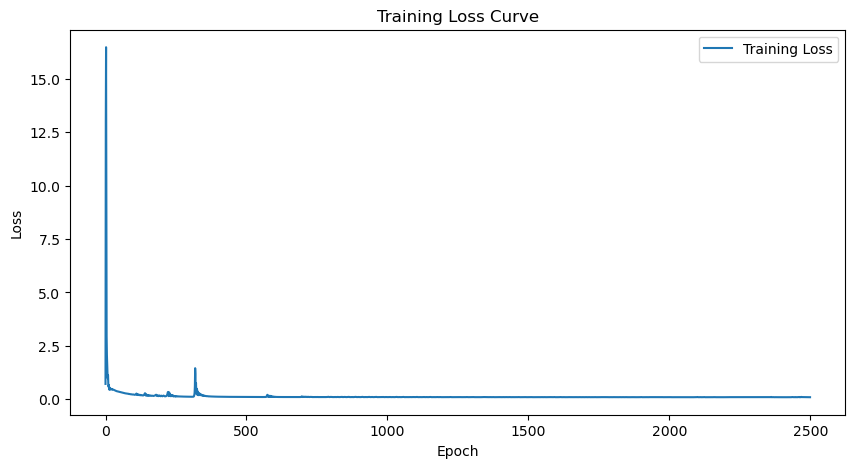

Best Model was saved at epoch 110 with F1-score 0.7338 and accuracy 70.87%


In [ ]:
input_dim = X_train.shape[1]
hidden_dim = 256

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [ ]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'.


In [ ]:
print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

Final Model Accuracy: 70.87%
                  precision    recall  f1-score   support

    infringement       0.78      0.60      0.68       195
non_infringement       0.66      0.82      0.73       186

        accuracy                           0.71       381
       macro avg       0.72      0.71      0.71       381
    weighted avg       0.72      0.71      0.71       381



/tmp/ipykernel_486172/3740627605.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()


: 